In [63]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import compose
import pathlib

In [64]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [65]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [66]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [67]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [93]:
def yield_batch(data):
    votes, answers = data
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id]
        x = np.zeros((1, *forecasts.shape))
        y = np.zeros((1, 4))
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield x, y

In [89]:
def yield_batch_val(data):
    votes, answers = data
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id]
            x = np.zeros((1, *forecasts.shape))
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [70]:
def yield_batch_test(data):
    item_ids = data.index.unique()
    for item_id in item_ids:
        forecasts = data.loc[item_id]
        x = np.zeros((1, *forecasts.shape))
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [71]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [110]:
def make_model(filters, input_shape, conv_l=6):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, input_shape))
    
    y_hot = layers.Lambda(lambda z: z[:, :, :-4])(y)
    y_coor = layers.Lambda(lambda z: z[:, :, -4:])(y)
    
    y_hot = layers.Dropout(0.2)(y_hot)  # 0.15 новых
    y_hot = layers.Dense(units=1, activation=None)(y_hot)
    
    y = layers.concatenate([y_hot, y_coor])
    
    for i in range(conv_l):
        y = layers.Conv1D(
            filters=filters,
            kernel_size=3,
            strides=1,
            padding="same"
        )(y)
    
    y = layers.GlobalAveragePooling1D()(y)
    
    y = layers.Dense(
        units=filters // 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [73]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [74]:
class DecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1, epsilon=0.0001, wait=3):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        self.epsilon=epsilon
        self.wait=wait
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None
        
        self.wait_count=None
        self.prev_loss=None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0.0
        self.d_loss = 0.0
        self.d_iterations = 0.0
        self.d_iterations2 = 0.0
        self.d_1 = 0.0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        self.wait_count=0
        self.prev_loss=None
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > 0:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}")
        
        if self.prev_loss is None:
            self.prev_loss = logs["val_loss"]
        elif abs(self.prev_loss - logs["val_loss"]) < self.epsilon:
            self.wait_count += 1
        else:
            self.wait_count = 0
        self.prev_loss = logs["val_loss"]
        print(f"Wait to stop: {self.wait - self.wait_count}\n")
        if self.wait == self.wait_count:
            self.model.stop_training = True
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [112]:
def train_model(data_train, data_val, units, test=False):
    
    max_lr = 1.4e-04
    
    steps_per_epoch = 1000
    epochs = 100
    
    model = make_model(units, data_train[0].shape[1])  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=len(data_val[1].index),
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=len(data_val[1].index),
        )
    
    model = models.load_model("../processed/model.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

W0727 18:16:56.408217 4623693248 deprecation.py:506] From /Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1361)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 1357)   0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 1357)   0           lambda_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 1)      1358        dropout_1[0][0]                  
__________________________________________________________________________________________________
lambda_2 (

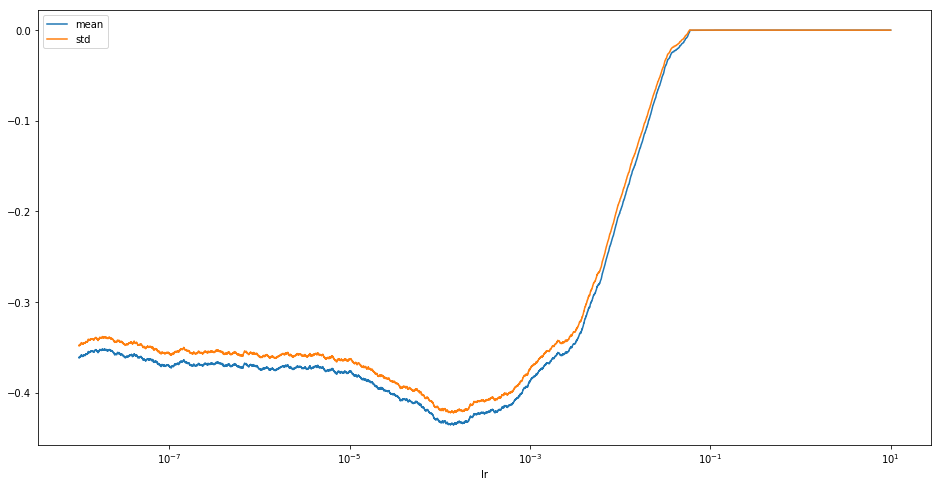

In [111]:
a, *_ = transform(votes, votes, votes)
train_model((a, answers), (a, answers), 64, True)[1].plot()

In [80]:
def transform(train, val, test):
    trans = compose.ColumnTransformer(
        [("onehot_id", preprocessing.OneHotEncoder(handle_unknown="ignore"), [0])],
        remainder="passthrough",
        sparse_threshold=0
    )
    train = pd.DataFrame(trans.fit_transform(train), index=train.index)
    val = pd.DataFrame(trans.transform(val), index=val.index)
    test = pd.DataFrame(trans.transform(test), index=test.index)
    return train, val, test

In [91]:
FOLDS = 10

def train_oof(train_set, test_set, units=64):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        x_train_t, x_val_t, x_test_t = transform(x_train.loc[ids_train], x_train.loc[ids_valid], x_test)
        
        data_train = (x_train_t, y_train.loc[ids_train])
        data_val = (x_val_t, y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test_t)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {2 * np.std(scores) / len(scores) ** 2:0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)

In [ ]:
train_oof((votes, answers), votes_test)


Fold - 1 / 10
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1306)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 1302)   0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 1302)   0           lambda_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 1)      1303        dropout_1[0][0]                  
______________________________________________________________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 7s 7ms/step - loss: -0.2886 - val_loss: -0.3631

Epoch 00001: val_loss improved from inf to -0.36311, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.3646
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4309 - val_loss: -0.4575

Epoch 00002: val_loss improved from -0.36311 to -0.45746, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.1163
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4505 - val_loss: -0.4724

Epoch 00003: val_loss improved from -0.45746 to -0.47240, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.0394
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4764 - val_loss: -0.4803

Epoch 00004: val_loss improved from -0.47240 to -0.48033, saving model to ../processed/model.h5
Learning rate:


Epoch 00034: val_loss improved from -0.57098 to -0.57099, saving model to ../processed/model.h5
Learning rate: 9.5e-07
Speed per epoch: 0.0008
Wait to stop: 3

Epoch 35/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5651 - val_loss: -0.5705

Epoch 00035: val_loss did not improve from -0.57099
Learning rate: 3.5e-07
Speed per epoch: 0.0041
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5803 - val_loss: -0.5707

Epoch 00036: val_loss did not improve from -0.57099
Learning rate: 2.2e-07
Speed per epoch: -0.0022
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5777 - val_loss: -0.5702

Epoch 00037: val_loss did not improve from -0.57099
Learning rate: 1.9e-07
Speed per epoch: -0.0017
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5800 - val_loss: -0.5705

Epoch 00038: val_loss did not improve from -0.57099
Learning 

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 7s 7ms/step - loss: -0.3003 - val_loss: -0.3401

Epoch 00001: val_loss improved from inf to -0.34005, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.3844
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4364 - val_loss: -0.4329

Epoch 00002: val_loss improved from -0.34005 to -0.43291, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.1134
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4392 - val_loss: -0.4624

Epoch 00003: val_loss improved from -0.43291 to -0.46245, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.0354
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4771 - val_loss: -0.4688

Epoch 00004: val_loss improved from -0.46245 to -0.46881, saving model to ../processed/model.h5
Learning rate:

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5810 - val_loss: -0.5460

Epoch 00035: val_loss improved from -0.54343 to -0.54603, saving model to ../processed/model.h5
Learning rate: 3.6e-06
Speed per epoch: -0.0024
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5796 - val_loss: -0.5434

Epoch 00036: val_loss did not improve from -0.54603
Learning rate: 2.9e-06
Speed per epoch: -0.0040
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5776 - val_loss: -0.5434

Epoch 00037: val_loss did not improve from -0.54603
Learning rate: 2.6e-06
Speed per epoch: 0.0002
Wait to stop: 2

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5788 - val_loss: -0.5445

Epoch 00038: val_loss did not improve from -0.54603
Learning rate: 1.4e-06
Speed per epoch: -0.0004
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 6s 6ms/step - lo

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.3042 - val_loss: -0.4117

Epoch 00001: val_loss improved from inf to -0.41171, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.3491
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4358 - val_loss: -0.4801

Epoch 00002: val_loss improved from -0.41171 to -0.48012, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.1163
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4692 - val_loss: -0.4554

Epoch 00003: val_loss did not improve from -0.48012
Learning rate: 1.4e-04
Speed per epoch: -0.0528
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4678 - val_loss: -0.4230

Epoch 00004: val_loss did not improve from -0.48012
Learning rate: 1.4e-04
Speed per epoch: -0.0214
Wait to stop: 3

Epoch 5/100
1000/1000 [==============

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5704 - val_loss: -0.5578

Epoch 00036: val_loss did not improve from -0.56589
Learning rate: 4.1e-07
Speed per epoch: -0.0006
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5657 - val_loss: -0.5583

Epoch 00037: val_loss did not improve from -0.56589
Learning rate: 1.7e-07
Speed per epoch: 0.0008
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5706 - val_loss: -0.5584

Epoch 00038: val_loss did not improve from -0.56589
Learning rate: 9.8e-08
Speed per epoch: -0.0011
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5694 - val_loss: -0.5584

Epoch 00039: val_loss did not improve from -0.56589
Learning rate: 5.8e-08
Speed per epoch: -0.0011
Wait to stop: 2

Epoch 40/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5706 - val_loss: -0.5584

Epoch 00040

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 7s 7ms/step - loss: -0.3203 - val_loss: -0.4100

Epoch 00001: val_loss improved from inf to -0.40997, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.3219
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4410 - val_loss: -0.4452

Epoch 00002: val_loss improved from -0.40997 to -0.44519, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.1017
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4618 - val_loss: -0.4376

Epoch 00003: val_loss did not improve from -0.44519
Learning rate: 1.4e-04
Speed per epoch: -0.0401
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4610 - val_loss: -0.4859

Epoch 00004: val_loss improved from -0.44519 to -0.48586, saving model to ../processed/model.h5
Learning rate: 1.4e-04
Speed per epoch: -0.0223
Wait to st

1000/1000 [==============================] - 7s 7ms/step - loss: -0.5823 - val_loss: -0.5482

Epoch 00036: val_loss did not improve from -0.55002
Learning rate: 2.1e-06
Speed per epoch: -0.0018
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5817 - val_loss: -0.5486

Epoch 00037: val_loss did not improve from -0.55002
Learning rate: 1.4e-06
Speed per epoch: -0.0002
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5887 - val_loss: -0.5488

Epoch 00038: val_loss did not improve from -0.55002
Learning rate: 1.1e-06
Speed per epoch: -0.0055
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5938 - val_loss: -0.5497

Epoch 00039: val_loss did not improve from -0.55002
Learning rate: 1.1e-06
Speed per epoch: -0.0045
Wait to stop: 3

Epoch 40/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5860 - val_loss: -0.5489

Epoch 0004